In [1]:
import tensorflow as tf
import keras
from keras.datasets import reuters
from keras.preprocessing.text import Tokenizer
import numpy as np
from keras.utils.np_utils import to_categorical
from keras import models
from keras import layers
import matplotlib.pyplot as plt
%matplotlib inline

C:\Users\Zippy\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Load text data encoded as numbers from [Reuters](https://www.reuters.com) news service. We want to use 40% of our data for testing, 50% of which (20% of the total data) will go towards validation and 50% will go towards actual testing. The remaining 60% will go towards training. 

In [2]:
#Get a dataset consisting of news snippets from Reuters. Maximum number of unique words is 10000.
(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=10000, test_split=0.4)

In [3]:
print("{0} train sequences".format(len(train_data)))
print("{0} test sequences".format(len(test_data)))

6736 train sequences
4492 test sequences


In [4]:
print(train_data[0])

[1, 2, 2, 8, 43, 10, 447, 5, 25, 207, 270, 5, 3095, 111, 16, 369, 186, 90, 67, 7, 89, 5, 19, 102, 6, 19, 124, 15, 90, 67, 84, 22, 482, 26, 7, 48, 4, 49, 8, 864, 39, 209, 154, 6, 151, 6, 83, 11, 15, 22, 155, 11, 15, 7, 48, 9, 4579, 1005, 504, 6, 258, 6, 272, 11, 15, 22, 134, 44, 11, 15, 16, 8, 197, 1245, 90, 67, 52, 29, 209, 30, 32, 132, 6, 109, 15, 17, 12]


The word index is a mapping of English words to numbers (so "bat" might be 10, "pole" might be 11, etc...). Use word index to get a reverse word index (mapping of numbers to English words), then print out first sentence in our training data for our inspection.

In [5]:
word_index = reuters.get_word_index()

reverse_word_index = {value : key for key, value in word_index.items()}

#The first two elements in the word index are reserved (don't map to an actual word)
decoded_newswire = ' '.join([reverse_word_index.get(i - 3, '?') for i in train_data[0]])

In [6]:
print(decoded_newswire)

? ? ? said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3


In [7]:
#Get number of classes we are going to classify (assuming we have at least one example of each class)
num_classes = np.max(train_labels) + 1
print(num_classes)

46


Daaaayum!

In [8]:
print(train_data[0])

[1, 2, 2, 8, 43, 10, 447, 5, 25, 207, 270, 5, 3095, 111, 16, 369, 186, 90, 67, 7, 89, 5, 19, 102, 6, 19, 124, 15, 90, 67, 84, 22, 482, 26, 7, 48, 4, 49, 8, 864, 39, 209, 154, 6, 151, 6, 83, 11, 15, 22, 155, 11, 15, 7, 48, 9, 4579, 1005, 504, 6, 258, 6, 272, 11, 15, 22, 134, 44, 11, 15, 16, 8, 197, 1245, 90, 67, 52, 29, 209, 30, 32, 132, 6, 109, 15, 17, 12]


In [9]:
print(test_data[0])

[1, 2469, 1231, 427, 3264, 282, 135, 32, 614, 35, 428, 28, 4, 153, 5, 48, 233, 22, 32, 948, 35, 10, 29, 157, 51, 25, 659, 249, 282, 333, 6, 102, 539, 3721, 1396, 983, 22, 102, 187, 3721, 4, 326, 303, 223, 8, 16, 8, 4, 499, 7, 317, 65, 9, 659, 249, 2883, 282, 1285, 2317, 5552, 5, 375, 828, 992, 27, 4, 769, 499, 7, 65, 87, 54, 29, 52, 1599, 13, 2859, 11, 428, 5, 10, 1338, 2317, 2666, 5, 2797, 11, 428, 31, 3320, 11, 428, 5, 4, 135, 2666, 2, 7, 4, 214, 212, 4, 223, 8, 2469, 8, 144, 62, 1807, 5552, 7, 4, 2011, 5, 25, 1338, 249, 282, 2357, 5549, 35, 1396, 983, 54, 29, 184, 16, 3757, 5211, 35, 1396, 983, 9, 1087, 4527, 35, 1396, 983, 5, 282, 122, 5, 68, 3721, 1396, 983, 1164, 389, 5, 405, 629, 4, 223, 8, 137, 5, 4, 249, 409, 766, 43, 339, 43, 137, 5, 4, 187, 11, 428, 5, 65, 282, 421, 7, 48, 62, 7, 4, 214, 212, 2469, 8, 1838, 16, 40, 2444, 19, 19, 35, 15, 6, 438, 37, 38, 814, 1110, 117, 4, 585, 109, 206, 2103, 21, 89, 2469, 8, 1092, 33, 30, 42, 7035, 359, 5, 380, 1462, 209, 282, 832, 554, 28, 

We need to convert our data and labels to one-hot vectors.

In [10]:
#Convert word indices into one-hot vectors (vectors that represent one word each.
#Each element except one is a zero. If the ith element is 1, then this vector
#represents the ith word)

tokenizer = Tokenizer(num_words=10000)

one_hot_train_data = tokenizer.sequences_to_matrix(train_data, mode='binary')

one_hot_test_data = tokenizer.sequences_to_matrix(test_data, mode='binary')

In [11]:
print(train_data[0][0:50])
print(one_hot_train_data[0])

[1, 2, 2, 8, 43, 10, 447, 5, 25, 207, 270, 5, 3095, 111, 16, 369, 186, 90, 67, 7, 89, 5, 19, 102, 6, 19, 124, 15, 90, 67, 84, 22, 482, 26, 7, 48, 4, 49, 8, 864, 39, 209, 154, 6, 151, 6, 83, 11, 15, 22]
[0. 1. 1. ... 0. 0. 0.]


In [12]:
one_hot_test_data[0]

array([0., 1., 1., ..., 0., 0., 0.])

In [13]:
one_hot_train_labels = to_categorical(train_labels, num_classes)
one_hot_test_labels = to_categorical(test_labels, num_classes)
print(len(train_labels))
print(len(one_hot_train_labels))
print(len(test_labels))
print(len(one_hot_test_labels))

6736
6736
4492
4492


Now, we must create our neural network. A neural network is really a sequence of layers of neurons.

In [14]:
model = models.Sequential()

#Create the input layer. The layer has 64 neurons and takes an input matrix wtih 10000 columns and some number of rows.
#The rows are individual words from one of the snippets in the Reuters data set. The columns are the values in the one-hot
#vectors (99999 zeros and one 1 to represent which of the 10000 words we are dealing with).
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))

model.add(layers.Dense(64, activation='relu'))

#This layer, the output layer, has 46 nodes corresponding to the 46
#possible output classes. It is necessary to have the same number of
#nodes as output classes in the last layer because the softmax function
#takes a K-dimensional vector of class scores and transforms it into a
#K-dimensional vector of class probabilities. K is determined by the number
#of nodes in the output layer (i.e., this layer), so we need the number of
#nodes to equal the number of classes. 
model.add(layers.Dense(46, activation='softmax'))

Now train the model. The `loss` parameter indicates which loss function we are using. In this case, we are using the cross-entropy function for categorical data. The `metric` is our success metric. In this case, it is accuracy (number of true positives plus number of true negatives quantity divided by number of guesses). The `optimizer` keyword is the training method to use.

In [15]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(one_hot_train_data, one_hot_train_labels, batch_size=512, epochs=20, verbose=1, validation_split=0.5)

Train on 3368 samples, validate on 3368 samples
Epoch 1/20
3368/3368 [==============================] - 1s 313us/step - loss: 3.1949 - acc: 0.4385 - val_loss: 2.3633 - val_acc: 0.5404
Epoch 2/20
3368/3368 [==============================] - 1s 237us/step - loss: 2.0245 - acc: 0.5656 - val_loss: 1.7943 - val_acc: 0.6149
Epoch 3/20
3368/3368 [==============================] - 1s 239us/step - loss: 1.5305 - acc: 0.6675 - val_loss: 1.5548 - val_acc: 0.6482
Epoch 4/20
3368/3368 [==============================] - 1s 247us/step - loss: 1.2501 - acc: 0.7355 - val_loss: 1.4100 - val_acc: 0.6918
Epoch 5/20
3368/3368 [==============================] - 1s 280us/step - loss: 1.0366 - acc: 0.7883 - val_loss: 1.3121 - val_acc: 0.7144
Epoch 6/20
3368/3368 [==============================] - 1s 283us/step - loss: 0.8710 - acc: 0.8224 - val_loss: 1.2590 - val_acc: 0.7227
Epoch 7/20
3368/3368 [==============================] - 1s 255us/step - loss: 0.7367 - acc: 0.8530 - val_loss: 1.1991 - val_acc: 0.7381


76% accuracy...not great, but not bad.

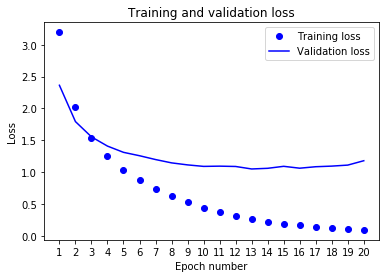

In [16]:
loss = history.history['loss'] #our training loss, with ith element representing
#the loss encountered during training in our ith epoch.
val_loss = history.history['val_loss'] #our testing loss, with ith element representing
#the loss encountered during training in our ith epoch.

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')

plt.plot(epochs, val_loss, 'b', label='Validation loss')

plt.title('Training and validation loss')

plt.xlabel('Epoch number')

plt.ylabel('Loss')

plt.xticks(range(1, len(loss) + 1), [str(i) for i in range(1, len(loss) + 1)])

plt.legend()

plt.show()

It looks like our validation loss has stabilized after a steep drop-off. Our training error plateaued slower, but it also looks like it has plateaued.

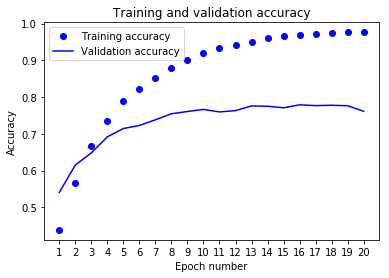

In [17]:
loss = history.history['acc'] #our training loss, with ith element representing
#the loss encountered during training in our ith epoch.
val_loss = history.history['val_acc'] #our testing loss, with ith element representing
#the loss encountered during training in our ith epoch.

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training accuracy')

plt.plot(epochs, val_loss, 'b', label='Validation accuracy')

plt.title('Training and validation accuracy')

plt.xlabel('Epoch number')

plt.ylabel('Accuracy')

plt.xticks(range(1, len(loss) + 1), [str(i) for i in range(1, len(loss) + 1)])

plt.legend()

plt.show()

Both of these have plateaued as well, but continuing to train has caused our model to overfit the training set with no real improvement on the validation set. We can probably train for fewer than 20 epochs (maybe 7 to 10 epochs instead) or increase regularization to avoid overfitting.

In [18]:
history = model.fit(one_hot_train_data, one_hot_train_labels, batch_size=512, epochs=10, verbose=1, validation_split=0.5)

Train on 3368 samples, validate on 3368 samples
Epoch 1/10
3368/3368 [==============================] - 1s 227us/step - loss: 0.0881 - acc: 0.9765 - val_loss: 1.1439 - val_acc: 0.7717
Epoch 2/10
3368/3368 [==============================] - 1s 235us/step - loss: 0.0803 - acc: 0.9774 - val_loss: 1.1420 - val_acc: 0.7782
Epoch 3/10
3368/3368 [==============================] - 1s 231us/step - loss: 0.0744 - acc: 0.9760 - val_loss: 1.1637 - val_acc: 0.7738
Epoch 4/10
3368/3368 [==============================] - 1s 264us/step - loss: 0.0669 - acc: 0.9789 - val_loss: 1.1796 - val_acc: 0.7773
Epoch 5/10
3368/3368 [==============================] - 1s 248us/step - loss: 0.0672 - acc: 0.9777 - val_loss: 1.2751 - val_acc: 0.7601
Epoch 6/10
3368/3368 [==============================] - 1s 250us/step - loss: 0.0608 - acc: 0.9783 - val_loss: 1.1842 - val_acc: 0.7809
Epoch 7/10
3368/3368 [==============================] - 1s 283us/step - loss: 0.0575 - acc: 0.9762 - val_loss: 1.3191 - val_acc: 0.7592


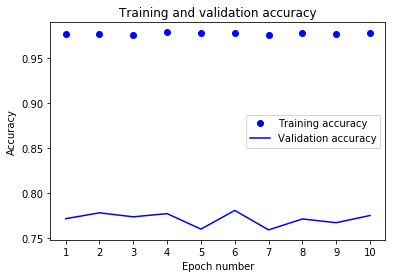

In [19]:
loss = history.history['acc'] #our training loss, with ith element representing
#the loss encountered during training in our ith epoch.
val_loss = history.history['val_acc'] #our testing loss, with ith element representing
#the loss encountered during training in our ith epoch.

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training accuracy')

plt.plot(epochs, val_loss, 'b', label='Validation accuracy')

plt.title('Training and validation accuracy')

plt.xlabel('Epoch number')

plt.ylabel('Accuracy')

plt.xticks(range(1, len(loss) + 1), [str(i) for i in range(1, len(loss) + 1)])

plt.legend()

plt.show()

In [20]:
score = model.evaluate(one_hot_test_data, one_hot_test_labels, batch_size=512, verbose=1)

print('Test accuracy: {0}'.format(score))

4492/4492 [==============================] - 0s 103us/step
Test accuracy: [1.314474996348523, 0.7715939447907391]


76% accuracy. That's not bad.